In [16]:
print('Ну типа тут вступление должно быть')

Ну типа тут вступление должно быть


In [17]:
from tqdm import tqdm
from os import system

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys

In [18]:
sns.set(style='darkgrid', font_scale=2, palette='Set1')

In [19]:
def prepare_drawing(xlabel, ylabel, title):
    plt.figure(figsize=(12, 8))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [20]:
def calculate_result(graph_size, seed=0):    
    !./generate_graph.sh {graph_size} {seed}
    res = !./run.sh
    if len(res) != 1:
        print(graph_size, seed, res)
        sys.stdout.flush()
        
    return int(res[0])

In [21]:
results = []

for graph_size in tqdm(range(2, 1000)):
    results.append(calculate_result(graph_size) / graph_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:33<00:00,  2.93it/s]


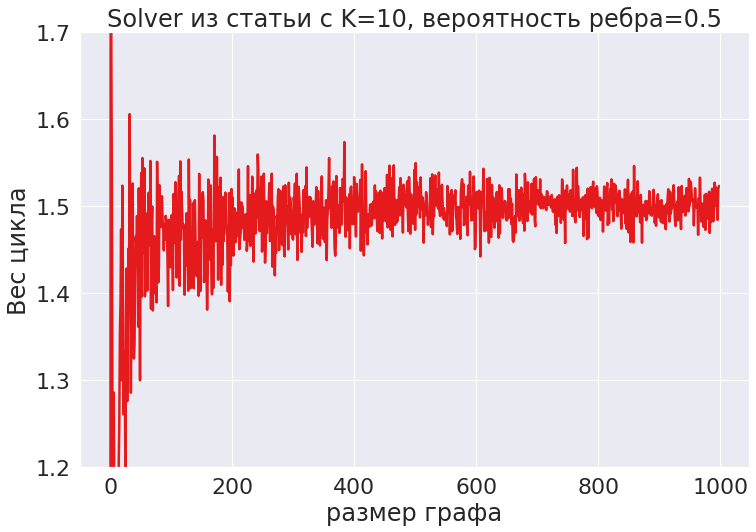

In [35]:
prepare_drawing('размер графа', 'Вес цикла', 'Solver из статьи с K=10, вероятность ребра=0.5')
#plt.xticks(np.arange(0, len(results) + 1, 5))
#plt.yticks(np.arange(0, len(results) + 1, 0.1))
plt.ylim((1.2, 1.7))
sns.lineplot(data=results, linewidth=2.5);

In [23]:

import pandas as pd

df = pd.DataFrame(np.array(results))
 
df.to_csv("original_solver_approximation_k1.csv")

In [29]:

results = np.genfromtxt('original_solver_approximation_k5.csv', delimiter=',')[:, 1]

In [30]:
results

array([0.        , 2.        , 1.66666667, 1.5       , 1.2       ,
       1.16666667, 1.28571429, 1.125     , 1.        , 1.        ,
       1.        , 1.16666667, 1.        , 1.07142857, 1.2       ,
       1.25      , 1.35294118, 1.38888889, 1.47368421, 1.3       ,
       1.52380952, 1.40909091, 1.26086957, 1.33333333, 1.32      ,
       1.19230769, 1.37037037, 1.42857143, 1.27586207, 1.36666667,
       1.4516129 , 1.40625   , 1.60606061, 1.41176471, 1.28571429,
       1.38888889, 1.37837838, 1.52631579, 1.35897436, 1.325     ,
       1.34146341, 1.42857143, 1.46511628, 1.45454545, 1.48888889,
       1.45652174, 1.36170213, 1.52083333, 1.40816327, 1.3       ,
       1.47058824, 1.53846154, 1.39622642, 1.55555556, 1.49090909,
       1.44642857, 1.54385965, 1.39655172, 1.40677966, 1.48333333,
       1.49180328, 1.40322581, 1.46031746, 1.515625  , 1.49230769,
       1.45454545, 1.55223881, 1.38235294, 1.47826087, 1.5       ,
       1.38028169, 1.44444444, 1.46575342, 1.45945946, 1.4    

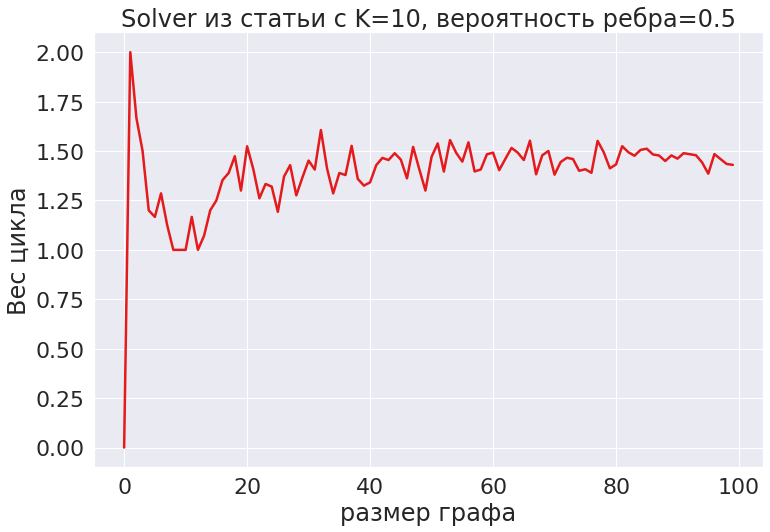

In [32]:
prepare_drawing('размер графа', 'Вес цикла', 'Solver из статьи с K=10, вероятность ребра=0.5')
#plt.xticks(np.arange(0, len(results) + 1, 5))
#plt.yticks(np.arange(0, len(results) + 1, 5))
sns.lineplot(data=results[:100], linewidth=2.5);